# PNEUMONIA DETECTOR

Saved model has 88.6% accuracy. The model is not very good at seperating viral pneumonias from bacterial ones as shown in the last section.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random,os,glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img

In [3]:
dir_path="/content/drive/MyDrive/Pneumonia/chest_xray"
train_path=f"{dir_path}/train"
test_path=f"{dir_path}/test"
val_path=f"{dir_path}/val"
target_size=(224,224)
class_labels={
    "NORMAL":0,
    "VIRUS":1,
    "BACTERIA":2
}


In [4]:
def load_subset(path):
  images=[]
  labels=[]

  image_paths=sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    img=cv2.imread(image_path)
    img=cv2.resize(img,target_size)
    images.append(img)
    img_name=image_path.split(os.path.sep)[-1]
    if("virus" in img_name):
      labels.append(class_labels["VIRUS"])
    elif("bacteria" in img_name):
      labels.append(class_labels["BACTERIA"])
    else:
      labels.append(class_labels["NORMAL"])

  images,labels=shuffle(images,labels,random_state=42)

  images=np.array(images)

  print(f"Image shape: {images.shape}")
  print(f"Unique label count: {len(np.unique(labels))}, Observation count: {len(labels)}")
  for key,value in class_labels.items():
    print(f"{key} observation count: {labels.count(value)}")

  return images,labels


In [5]:
x_train,y_train = load_subset(train_path)

Image shape: (5216, 224, 224, 3)
Unique label count: 3, Observation count: 5216
NORMAL observation count: 1341
VIRUS observation count: 1345
BACTERIA observation count: 2530


In [6]:
x_test,y_test = load_subset(test_path)

Image shape: (624, 224, 224, 3)
Unique label count: 3, Observation count: 624
NORMAL observation count: 234
VIRUS observation count: 148
BACTERIA observation count: 242


In [7]:
def visualize_img(image_batch,label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax=plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(class_labels.keys()))[to_categorical(y_train,num_classes=3)[n]==1][0].title())
    plt.axis("off")

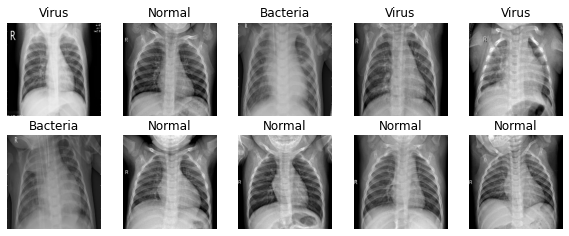

In [8]:
visualize_img(x_train,y_train)

In [9]:
y_train = to_categorical(y_train,3)
y_test = to_categorical(y_test,3)

In [10]:
input_shape=(x_train[0].shape[1],x_train[0].shape[1],3)
print(input_shape)

(224, 224, 3)


In [11]:
train_datagen=ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255
)

test_datagen=ImageDataGenerator(
    rescale=1./255
)

In [12]:
train_generator = train_datagen.flow(
        x_train,
        y_train,
        batch_size=128)
test_generator = test_datagen.flow(
        x_test,
        y_test,
        batch_size=128)

In [13]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same",activation="relu"))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same",activation="relu"))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
model.add(Dropout(rate=0.1))

model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu"))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu"))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
model.add(Dropout(rate=0.1))

model.add(Flatten())

model.add(Dense(units=128,activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=64,activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=3,activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                        

In [15]:
model.compile(loss="categorical_crossentropy",
              optimizer= "adam",
              metrics=["accuracy"])

callbacks=[EarlyStopping(monitor="val_loss",patience=25,verbose=1,mode="min"),
           ModelCheckpoint(filepath="pneumonia_detector.h5",monitor="val_accuracy",mode="max",save_best_only=True,save_weights_only=False,verbose=1)]

In [16]:
history=model.fit(
    x=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(x_train)//128,
    epochs=100,
    callbacks=callbacks,
    workers=4
)

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 1.1079 - accuracy: 0.4672
Epoch 1: val_accuracy improved from -inf to 0.38782, saving model to pneumonia_detector.h5
40/40 [==============================] - 136s 3s/step - loss: 1.1079 - accuracy: 0.4672 - val_loss: 1.1168 - val_accuracy: 0.3878
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 1.0561 - accuracy: 0.4851
Epoch 2: val_accuracy did not improve from 0.38782
40/40 [==============================] - 73s 2s/step - loss: 1.0561 - accuracy: 0.4851 - val_loss: 1.1072 - val_accuracy: 0.3878
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 1.0530 - accuracy: 0.4853
Epoch 3: val_accuracy did not improve from 0.38782
40/40 [==============================] - 73s 2s/step - loss: 1.0530 - accuracy: 0.4853 - val_loss: 1.1062 - val_accuracy: 0.3878
Epoch 4/100
40/40 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.4851
Epoch 4: val_accuracy did not improve f

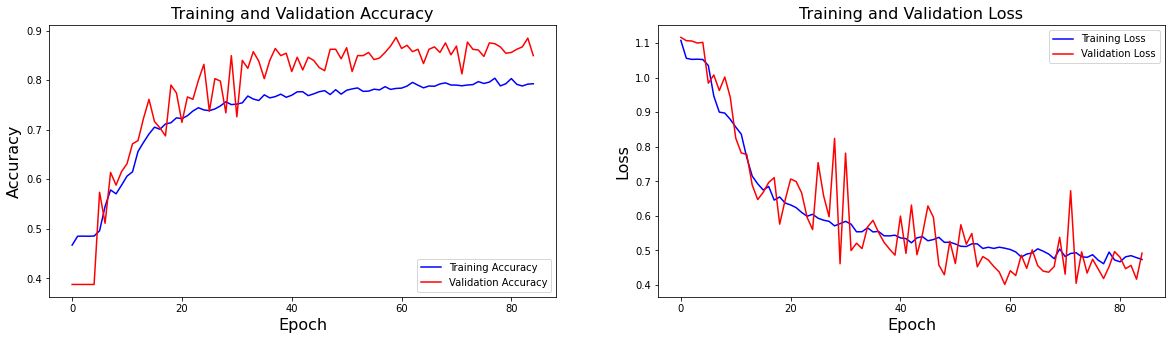

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],color="b",label="Training Accuracy")
plt.plot(history.history["val_accuracy"],color="r",label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.title("Training and Validation Accuracy", fontsize=16)


plt.subplot(1,2,2)
plt.plot(history.history["loss"],color="b",label="Training Loss")
plt.plot(history.history["val_loss"],color="r",label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.title("Training and Validation Loss", fontsize=16)

plt.show()

In [18]:
x_test,y_test=test_generator.next()
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

target_names=list(class_labels.keys())

4/4 [==============================] - 3s 101ms/step


In [19]:
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

      NORMAL       1.00      0.84      0.91        56
       VIRUS       0.68      0.63      0.65        27
    BACTERIA       0.80      1.00      0.89        45

    accuracy                           0.85       128
   macro avg       0.83      0.82      0.82       128
weighted avg       0.86      0.85      0.85       128



In [20]:
cm=confusion_matrix(y_test,y_pred)

def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
  
  if normalize:
    cm=cm.astype("float") / cm.sum(axis=1)[:,np.newaxis]
  
  plt.figure(figsize=(8,6))
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)
  fmt=".2f" if normalize else "d"
  thresh = cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Label",fontweight="bold")
  plt.xlabel("Predicted Label",fontweight="bold")

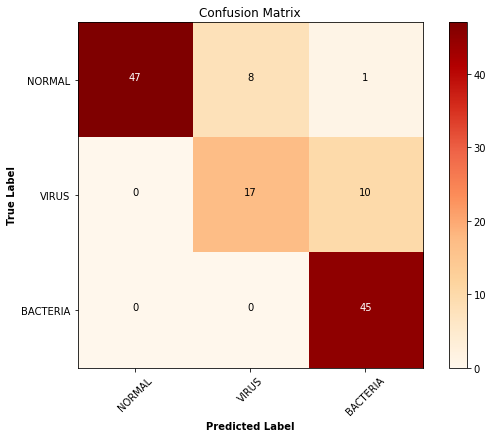

In [21]:
plot_confusion_matrix(cm,class_labels.keys(),
                         title="Confusion Matrix",
                         cmap=plt.cm.OrRd)

In [22]:
def model_predict(path):
  img=image.load_img(path,target_size=(target_size))
  img=image.img_to_array(img,dtype=np.uint8)
  img=np.array(img) / 255.0
  p=model.predict(img.reshape(1,224,224,3))
  predicted_class=np.argmax(p[0])

  return img,p,predicted_class

1/1 [==============================] - 0s 31ms/step


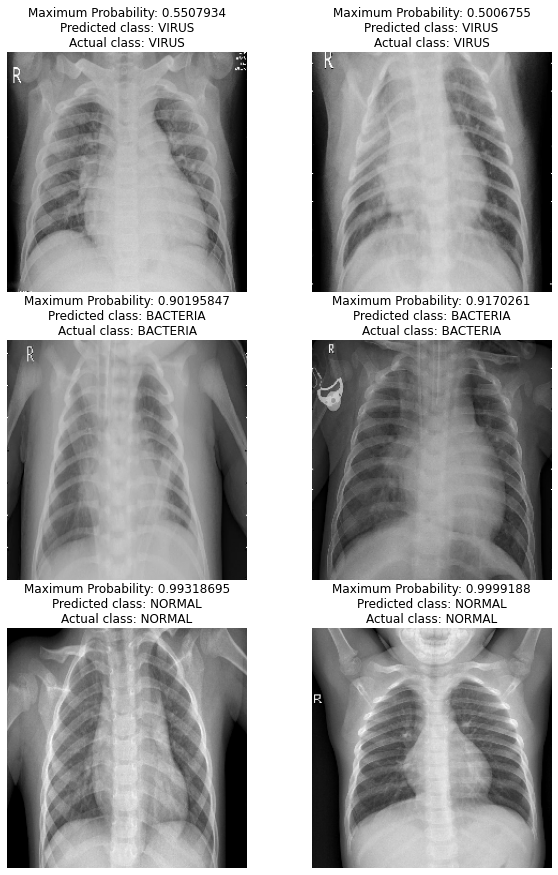

In [51]:
test_list=[
    "/content/drive/MyDrive/Pneumonia/chest_xray/test/PNEUMONIA/person21_virus_52.jpeg",
    "/content/drive/MyDrive/Pneumonia/chest_xray/test/PNEUMONIA/person31_virus_70.jpeg",
    "/content/drive/MyDrive/Pneumonia/chest_xray/test/PNEUMONIA/person78_bacteria_380.jpeg",
    "/content/drive/MyDrive/Pneumonia/chest_xray/test/PNEUMONIA/person80_bacteria_391.jpeg",
    "/content/drive/MyDrive/Pneumonia/chest_xray/test/NORMAL/IM-0075-0001.jpeg",
    "/content/drive/MyDrive/Pneumonia/chest_xray/test/NORMAL/IM-0103-0001.jpeg"
]

class_labels={0:"NORMAL",1:"VIRUS",2:"BACTERIA"}

plt.figure(figsize=(10,15))

for index,path in enumerate(test_list):
  img,p,predicted_class=model_predict(path)
  actual_class=""
  if("virus" in path):
    actual_class="VIRUS"
  elif("bacteria" in path):
    actual_class="BACTERIA"
  else:
     actual_class="NORMAL"   
  plt.subplot(3,2,index+1)
  plt.axis("off")
  plt.title("Maximum Probability: "+str(np.max(p[0],axis=-1))+"\n"+"Predicted class: "+str(class_labels[predicted_class]+"\n"+"Actual class: "+actual_class))
  plt.imshow(img)


In [30]:
tflite_model = tf.keras.models.load_model('pneumonia_detector.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("pneumonia_detector.tflite", "wb").write(tflite_save)

81963580